## LSTM Modelling

We will start off this notebook by building an Bi-LSTM model using Tensorflow Keras with GloVe embedding.  
As our Airbnb reviews dataset itself is not pre-annotated, it cannot be used to train the model unless we manual annotate / use existing tool to annotate the entire dataset.  

Thus, we will use an existing pre-annotated dataset to train our LSTM NER model and then re-train the model on a small manually-annotated dataset of Airbnb reviews.

## Imports

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.model_selection import train_test_split

In [2]:
# Imports
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:
# Imports
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import load_model

from seqeval.metrics import classification_report

## Data Import & Cleaning & Preprocessing

This dataset is downloadable from Kaggle. It is from the Groningen Meaning Bank ([GMB](https://gmb.let.rug.nl)), which is developed at the University of Groningen. It comprises of thousands of texts in raw and tokenised format, tags for part of speech, named entities and lexical categories.

Source: https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

In [4]:
# Read csv
data = pd.read_csv('../data/ner_dataset.csv')

In [5]:
# Check df
data

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [6]:
# Check data type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [7]:
# Check for null values
data.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [8]:
# For our null values, we will use forward-fill method because the words are from the same sentence
data.fillna(method='ffill', inplace=True)

In [9]:
# Check df
data

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
...,...,...,...,...
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O


In [10]:
#Make all column names lowercase
#Replace all space with non-space
data.columns = data.columns.str.lower().str.replace(' ','')

In [11]:
# Check number of tag types
n_tag = data['tag'].nunique()
n_tag

17

In [12]:
# Check amount of unique words
data['word'].nunique()

35172

In [13]:
# Observe the most frequently used words
data['word'].value_counts()[0:30]

the     52573
.       47761
,       32754
of      26354
in      26323
to      23213
a       20481
and     19936
The     11313
's      10923
for      8498
has      7216
is       6746
on       6710
that     6301
have     5485
with     5381
said     5321
was      4878
says     4640
from     4539
by       4482
at       4343
say      4178
U.S.     4129
as       4106
an       3845
are      3718
"        3686
were     3519
Name: word, dtype: int64

Most of the words within the corpus are stopwords. However, it might not be wise to remove them from our dataset, as we might lose some context when the model learns through the sequence of words.

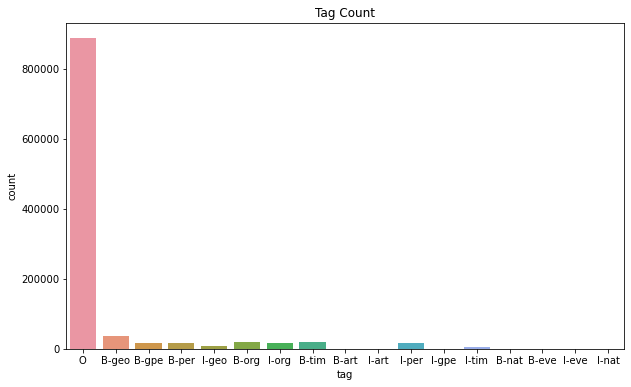

In [14]:
# Observe the distribution of tags
fig = plt.figure(figsize=(10,6))
sns.countplot(data=data, x='tag')
plt.title('Tag Count');

- Most of the tags are 'O', so we can deduce that our dataset is not very rich in named entities
- The second highest count is 'geo' for geographical entity. Because the 'B' format is much higher than 'I', it is very likely that most of the 'geo' entities are of single-words
- Same goes for 'gpe' or geopolitical entities
- However, 'per' or person and 'org' for organization are likelier to have more than one word in the entities
- The art, event and nature categories are almost non-existent
- **Due to the imbalanced classes, we will need to use other metrics (not accuracy) when we perform modelling**

Before we start modelling, we need to process our data into numbers that our model can take in.  
For the words, we will use the Keras tokenizer and text-to-sequence function.  
However, we will manually change our tags into numbers so that we can apply the Keras to-categorical function.  

In [15]:
# Tokenize labels into numerics
vocab = list(set(data['tag'].to_list()))

# Create dictionary of each tokens
tag_idx = {tag:idx for  idx, tag in enumerate(vocab)}
idx_tag = {idx:tag for  idx, tag in enumerate(vocab)}

# Use map function to get the converted labels
data['tag_idx'] = data['tag'].map(tag_idx)

In [16]:
# Check dictionary of tags
tag_idx

{'I-art': 0,
 'I-nat': 1,
 'B-tim': 2,
 'I-gpe': 3,
 'I-tim': 4,
 'B-geo': 5,
 'B-eve': 6,
 'B-org': 7,
 'B-per': 8,
 'B-art': 9,
 'I-eve': 10,
 'I-per': 11,
 'B-nat': 12,
 'B-gpe': 13,
 'I-geo': 14,
 'O': 15,
 'I-org': 16}

In [17]:
# Convert the data into a list format (reason: to merge them together using groupby function)
data['word'] = [[tok] for tok in data['word']]
data['pos'] = [[tok] for tok in data['pos']]
data['tag'] = [[tok] for tok in data['tag']]
data['tag_idx'] = [[tok] for tok in data['tag_idx']]

In [18]:
# Check df
data

,sentence#,word,pos,tag,tag_idx
0,Sentence: 1,[Thousands],[NNS],[O],[15]
1,Sentence: 1,[of],[IN],[O],[15]
2,Sentence: 1,[demonstrators],[NNS],[O],[15]
3,Sentence: 1,[have],[VBP],[O],[15]
4,Sentence: 1,[marched],[VBN],[O],[15]
...,...,...,...,...,...
1048570,Sentence: 47959,[they],[PRP],[O],[15]
1048571,Sentence: 47959,[responded],[VBD],[O],[15]
1048572,Sentence: 47959,[to],[TO],[O],[15]
1048573,Sentence: 47959,[the],[DT],[O],[15]


In [19]:
# Merge the data together using the groupby function (grouped by 'sentence#')
data = data.groupby('sentence#').agg({'word':'sum','pos':'sum',
                                      'tag':'sum','tag_idx':'sum'}).reset_index()

In [20]:
# Check df
data

,sentence#,word,pos,tag,tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[15, 15, 15, 15, 15, 15, 5, 15, 15, 15, 15, 15..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[15, 15, 2, 15, 15, 15, 15, 15, 5, 15, 15, 15,..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[5, 15, 15, 8, 11, 15, 2, 15, 5, 15, 13, 15, 1..."
...,...,...,...,...,...
47954,Sentence: 9995,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[NNP, NN, NNP, NNP, NNP, VBZ, VBN, PRP, VBZ, T...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O...","[15, 15, 15, 8, 11, 15, 15, 15, 15, 15, 15, 15..."
47955,Sentence: 9996,"[On, Thursday, ,, Iranian, state, media, publi...","[IN, NNP, ,, JJ, NN, NNS, VBN, DT, NN, IN, DT,...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B...","[15, 2, 15, 13, 15, 15, 15, 15, 15, 15, 15, 15..."
47956,Sentence: 9997,"[Following, Iran, 's, disputed, June, 12, elec...","[VBG, NNP, POS, JJ, NNP, CD, NNS, ,, NNS, NNS,...","[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ...","[15, 5, 15, 15, 2, 4, 15, 15, 15, 15, 15, 15, ..."
47957,Sentence: 9998,"[Since, then, ,, authorities, have, held, publ...","[IN, RB, ,, NNS, VBP, VBN, JJ, NNS, IN, DT, VB...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1..."


In [21]:
# Compute the length of each sentence to know the maximum length
data['len'] = [len(sent) for sent in data['tag']]

In [22]:
# Check df
data

,sentence#,word,pos,tag,tag_idx,len
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[15, 15, 15, 15, 15, 15, 5, 15, 15, 15, 15, 15...",24
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...",25
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[15, 15, 2, 15, 15, 15, 15, 15, 5, 15, 15, 15,...",32
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]",11
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[5, 15, 15, 8, 11, 15, 2, 15, 5, 15, 13, 15, 1...",35
...,...,...,...,...,...,...
47954,Sentence: 9995,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[NNP, NN, NNP, NNP, NNP, VBZ, VBN, PRP, VBZ, T...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O...","[15, 15, 15, 8, 11, 15, 15, 15, 15, 15, 15, 15...",32
47955,Sentence: 9996,"[On, Thursday, ,, Iranian, state, media, publi...","[IN, NNP, ,, JJ, NN, NNS, VBN, DT, NN, IN, DT,...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B...","[15, 2, 15, 13, 15, 15, 15, 15, 15, 15, 15, 15...",25
47956,Sentence: 9997,"[Following, Iran, 's, disputed, June, 12, elec...","[VBG, NNP, POS, JJ, NNP, CD, NNS, ,, NNS, NNS,...","[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ...","[15, 5, 15, 15, 2, 4, 15, 15, 15, 15, 15, 15, ...",27
47957,Sentence: 9998,"[Since, then, ,, authorities, have, held, publ...","[IN, RB, ,, NNS, VBP, VBN, JJ, NNS, IN, DT, VB...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...",21


<Figure size 720x432 with 0 Axes>

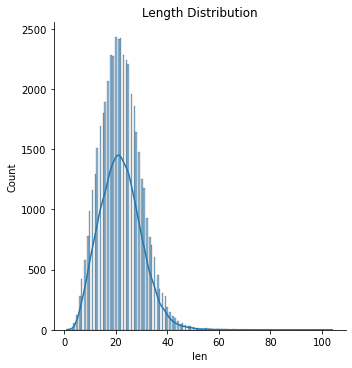

In [23]:
# Plot and observe the distribution of the length of words per sentence
fig = plt.figure(figsize=(10,6))
sns.displot(data=data, x='len', kde=True)
plt.title('Length Distribution');

As observed from our distribution curve above, most of the sentences have a length of around 15 to 30 words.  
Almost all of the sentences lie within the region below 60 words.

One consideration was to truncate sentences to a max of 60 as suggested above, but we decided not to proceed because the gap to the max length is not very far. Hence, the amount of padding that needs to be applied to the sentences is not too big (let's say 1000 words, then it would be too computational expensive).

Another reason is because we are going to apply this model onto our Airbnb dataset, which at this point we may not know the distribution of words in it. Hence, we will proceed with the max length.

In [24]:
# Check max length
max_len = max(data['len'])
max_len

104

We will use max length of 104 to build our LSTM model

In [25]:
# Set labels
labels = data['tag_idx'].tolist()

# Check type of data in list
type(labels[0][0])

int

In [26]:
# Set docs - these are our features
docs = data['word'].tolist()

In [27]:
# Manually slice train-test set to 80-20 size
training_sentences = docs[0:38400]
testing_sentences = docs[38400:]

training_labels = labels[0:38400]
testing_labels = labels[38400:]

In [28]:
# Instantiate Keras Tokenizer, set untrained words as 'OOV' Out of Vocabulary
tokenizer = Tokenizer(oov_token='<OOV>') 
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

In [29]:
# Check the num of words in our word index
n_words = len(tokenizer.word_index)+1
n_words

28824

Our word_index only has 28K words, but our dataset has more than 30K of words.  
Thus, there are a few thousand words that our model will need to learn by itself.  
This may not be helpful in increasing the accuracy of our model.

In [30]:
# Set parameters of the text-to-sequence function
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [31]:
# Convert our words into sequences (list of numbers)
# Then pad the sequences to the exact length of max length (104)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type) #,value=word_index['<OOV>']

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [32]:
# Pad labels so that dimension is the same as input
train_labels_pad = pad_sequences(sequences=training_labels, maxlen=max_len, padding=padding_type, 
                                 truncating=trunc_type, value=tag_idx.get('O'))
test_labels_pad = pad_sequences(sequences=testing_labels, maxlen=max_len, padding=padding_type, 
                                truncating=trunc_type, value=tag_idx.get('O'))

train_labels_padded = [to_categorical(i, num_classes=n_tag) for i in train_labels_pad]
test_labels_padded = [to_categorical(i, num_classes=n_tag) for i in test_labels_pad]

In [33]:
# Check shape
training_padded.shape

(38400, 104)

In [34]:
# Check shape
len(test_labels_padded)

9559

In [35]:
# Convert lists to array before feeding into model
training_padded = np.array(training_padded)
training_labels = np.array(train_labels_padded)
testing_padded = np.array(testing_padded)
testing_labels = np.array(test_labels_padded)

## GloVe Embedding, Bi-LSTM Modelling & Prediction

For our word embedding, we will utilize the GloVe (Global Vectors for Word Representation) embedding from [Stanford](https://nlp.stanford.edu/projects/glove/). We will be using their pre-trained word vectors of 50D and 100D dimension size.  
The general intuition on GloVe is that GloVe focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together.

In [36]:
# Set num of features in embedding (word embedding size)
output_dim = 100

In [37]:
# After downloading the embedding txt file, please put the file into a folder called 'glove' under 'data'
embeddings_index = {}
f = open('../data/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [38]:
print('Found %s unique tokens.' % len(word_index))

Found 28823 unique tokens.


The GloVe embedding has a total of 400,000 words, while our training dataset only uses 28,000 words.  
We will need to extract out the vectors of each word inside our training dataset from GloVe.

In [39]:
# Set dimension size
embedding_dim = 100

# If there is any unknown elements, we will input all zeros for that word in the embedding
unknown_element = [0]*100

# First create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((n_words, embedding_dim))

# For each word in our tokenizer, we will map that word out of GloVe
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # If found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # If doesn't exist, assign a zeros vector
        embedding_matrix[i] = unknown_element

In [40]:
# Check matrix
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02767   ,  0.055429  ,  0.0048339 , ...,  0.49401999,
        -0.83863002, -0.59442002],
       [ 0.010828  , -0.20599   , -0.52205998, ...,  0.35444   ,
        -0.36763   , -0.31011999]])

We will now create an LSTM model which will produce probability distribution over tags for each token in a sentence. To take into account both right and left contexts of the token, we will use Bi-Directional LSTM (Bi-LSTM) layer. A time-distributed dense layer will be used on top to perform multi-class tag classification.

In [41]:
# Create sequential
model = Sequential()

# Add Embedding layer
model.add(Embedding(input_dim=n_words, output_dim=output_dim, input_length=max_len, 
                    embeddings_initializer=Constant(embedding_matrix), trainable=True))

# Add bidirectional LSTM
model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.0, recurrent_dropout=0.0), 
                        merge_mode = 'concat'))

# Add timeDistributed Layer
model.add(TimeDistributed(Dense(17, activation="softmax")))

#model.add(Dense(32, activation="relu"))

In [42]:
# Due to the imbalanced class, we will optimize our model using recall
recall = Recall()
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=[recall])

Why pick recall over precision?
Precision means that an algorithm returns more relevant results than irrelevant ones, and high recall means that an algorithm returns most of the relevant results (whether or not irrelevant ones are also returned). For our case, we might want our model to return some irrelevant ones (that could be a place).

In [43]:
# Check model topology
model.summary(line_length=90)

Model: "sequential"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
embedding (Embedding)                   (None, 104, 100)                    2882400       
__________________________________________________________________________________________
bidirectional (Bidirectional)           (None, 104, 200)                    160800        
__________________________________________________________________________________________
time_distributed (TimeDistributed)      (None, 104, 17)                     3417          
Total params: 3,046,617
Trainable params: 3,046,617
Non-trainable params: 0
__________________________________________________________________________________________


In [44]:
# Fit and train model
num_epochs = 4
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs, validation_data=(testing_padded, testing_labels),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=1)])

Epoch 1/4
1200/1200 [==============================] - 213s 177ms/step - loss: 0.2048 - recall: 0.9276 - val_loss: 0.0312 - val_recall: 0.9889
Epoch 2/4
1200/1200 [==============================] - 224s 187ms/step - loss: 0.0266 - recall: 0.9905 - val_loss: 0.0283 - val_recall: 0.9896
Epoch 3/4
1200/1200 [==============================] - 245s 204ms/step - loss: 0.0207 - recall: 0.9925 - val_loss: 0.0265 - val_recall: 0.9905
Epoch 4/4
1200/1200 [==============================] - 251s 209ms/step - loss: 0.0176 - recall: 0.9935 - val_loss: 0.0268 - val_recall: 0.9912


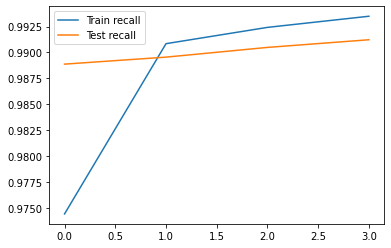

In [45]:
# Check recall curve
plt.plot(history.history['recall'], label='Train recall')
plt.plot(history.history['val_recall'], label='Test recall')
plt.legend()

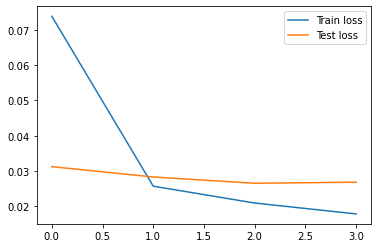

In [46]:
# Check loss curve
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.legend()

In [47]:
# Find the most probable tags with argmax.
pred_labels = np.argmax(model.predict(testing_padded), axis=-1)

In [48]:
# Check testing label shape
test_labels_pad.shape

(9559, 104)

In [49]:
# Check predicted label shape
pred_labels.shape

(9559, 104)

In [50]:
# Create temp df
temp_df = pd.DataFrame()

# Number the labels
temp_df['num'] = [i for i in range(len(pred_labels))]

# Get model predicted labels
# Then convert back to original tag
temp_df['pred_labels'] = pred_labels.tolist()
temp_df['pred_labels'] = temp_df['pred_labels'].apply(lambda row: [idx_tag[v] for v in row if idx_tag.get(v)])

# Get model test labels
# Then convert back to original tag
temp_df['test_labels'] = test_labels_pad.tolist()
temp_df['test_labels'] = temp_df['test_labels'].apply(lambda row: [idx_tag[v] for v in row if idx_tag.get(v)])

# Check df
temp_df

,num,pred_labels,test_labels
0,0,"[B-geo, O, O, O, O, O, O, O, O, O, O, O, B-gpe...","[B-org, O, O, O, O, O, O, O, O, O, O, O, B-gpe..."
1,1,"[O, O, O, O, O, O, O, O, O, O, O, B-org, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, B-org, O, O,..."
2,2,"[O, B-gpe, I-gpe, O, O, B-org, I-org, O, B-tim...","[O, B-gpe, I-gpe, O, O, B-org, I-org, O, B-tim..."
3,3,"[O, O, O, O, O, O, O, B-geo, O, O, O, O, B-geo...","[O, O, O, O, O, O, O, B-geo, O, O, O, O, B-geo..."
4,4,"[O, O, O, O, B-tim, I-tim, O, O, O, O, O, O, O...","[O, O, O, O, B-tim, I-tim, O, O, O, O, O, O, O..."
...,...,...,...
9554,9554,"[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O..."
9555,9555,"[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, O...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B..."
9556,9556,"[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ...","[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ..."
9557,9557,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [51]:
# Check model performance
print(classification_report(temp_df['test_labels'], temp_df['pred_labels'], zero_division=0))

              precision    recall  f1-score   support

         art       0.18      0.02      0.04        83
         eve       0.56      0.28      0.37        68
         geo       0.84      0.84      0.84      7461
         gpe       0.96      0.92      0.94      3369
         nat       0.73      0.21      0.32        39
         org       0.61      0.54      0.57      3997
         per       0.70      0.72      0.71      3314
         tim       0.87      0.84      0.86      4064

   micro avg       0.80      0.78      0.79     22395
   macro avg       0.68      0.55      0.58     22395
weighted avg       0.80      0.78      0.79     22395



The seqeval package very conveniently helps us to analyse our model results down to the entity-level. Hence we can straight away observe the precision, recall and f1-score for each separate class.  
As we already know that we have imbalanced classes, we will choose f1-score as our evaluation metric.

Next, we will need to pick either micro or macro score:  
macro - takes an average of all f1s for individual classes (treating all classes equally)  
micro - aggregate the contributions of all classes' precision and recall to compute the average metric  (treat all samples equally)

Since we are interested in having our model making sure that the most cases, regardless of class, are assigned to the correct class  we will use micro-avg score.

Hence, our model is able to reach an f1-score of 0.79

In [52]:
# Check what are the distribution of misclassified tags

# Create temp df
cdf = temp_df[['num','test_labels','pred_labels']]

# Un-nest the list to compare the tag by each individual word
cdf = cdf.apply(pd.Series.explode)

# If predicted and test tag is different, then label them apart
cdf = cdf[cdf['test_labels']!=cdf['pred_labels']]
cdf['change'] = cdf['test_labels']+' '+cdf['pred_labels']

# Check top10 misclassified tag direction
pd.set_option('display.max_rows', 200)
cdf['change'].value_counts()[0:10]

I-org O        886
B-org O        762
B-geo O        510
B-org B-geo    451
B-tim O        410
B-per O        290
O I-org        272
B-geo B-org    254
O B-org        210
I-tim O        194
Name: change, dtype: int64

Our model seems to misclassify a lot of 'org' tags are 'O' and vice versa, 'O' tags into 'org'.  
Let's look at some misclassified words by our mode below.

In [53]:
# Check tags to see weakness
ct = pd.DataFrame()
ct['sentence'] = testing_sentences[0]
ct['test'] = temp_df['test_labels'][0][0:len(testing_sentences[0])]
ct['pred'] = temp_df['pred_labels'][0][0:len(testing_sentences[0])]

ct

,sentence,test,pred
0,Turkey,B-org,B-geo
1,is,O,O
2,the,O,O
3,only,O,O
4,country,O,O
5,that,O,O
6,recognizes,O,O
7,the,O,O
8,government,O,O
9,of,O,O


Misclassification of B-org to B-geo was 3rd on the list.  
As seen above, our model misclassified Cyprus as B-geo instead of B-org.

In [54]:
# Check tags to see weakness
i = 999
ct = pd.DataFrame()
ct['sentence'] = testing_sentences[i]
ct['test'] = temp_df['test_labels'][i][0:len(testing_sentences[i])]
ct['pred'] = temp_df['pred_labels'][i][0:len(testing_sentences[i])]

ct

,sentence,test,pred
0,Meanwhile,O,O
1,",",O,O
2,a,O,O
3,Vatican,B-org,O
4,spokesman,O,O
5,says,O,O
6,kidnappers,O,O
7,have,O,O
8,freed,O,O
9,the,O,O


Over here we can see other types of misclassification, such as the model not recognising the archbishop's first name Basile (perhaps its not in the training embedding) and the model did not recognise Catholic Church as an organization, but a person.

## Retrain Using Annotated Samples of Airbnb Review Dataset

Now that our model has been pre-trained, we will now use a small sample size (125rows of dataset) from our Airbnb reviews to retrain our model.  

This is the 'bootstrapping' method, and will allow our model to learn about our Airbnb corpus (without training / learning from the entire corpus).

**Please refer to the notebook 'manual_sampled_annotation' within the 'support' folder.  
The code on the sample extraction and preprocessing done are within**

In [55]:
# Read csv
data_sample = pd.read_csv('../data/manual_annotate_sample.csv')
data_sample.drop(columns='Unnamed: 0', inplace=True)

# Use map to change the labels as done above
data_sample['tag_idx'] = data_sample['tag'].map(tag_idx)

In [56]:
# Check df
data_sample

,num,sentence,tag,tag_idx
0,1,This,O,15
1,1,was,O,15
2,1,a,O,15
3,1,great,O,15
4,1,place,O,15
...,...,...,...,...
8038,125,Kelvin,B-per,8
8039,125,is,O,15
8040,125,place,O,15
8041,125,again,O,15


In [57]:
# Check tag types
data_sample['tag_idx'].unique()

array([15, 13,  5, 14,  7, 16,  3,  8, 11])

In [58]:
# Convert all entries into list type
data_sample['sentence'] = [[tok] for tok in data_sample['sentence']]
data_sample['tag'] = [[tok] for tok in data_sample['tag']]
data_sample['tag_idx'] = [[tok] for tok in data_sample['tag_idx']]

In [59]:
# Using groupby function, agg sum all up by id num
data_sample = data_sample.groupby('num').agg({'sentence':'sum',
                                              'tag':'sum','tag_idx':'sum'}).reset_index()

In [60]:
# Check shape of sample
data_sample.shape

(125, 4)

In [61]:
# Repeat what had been done above for first model training

# Assign labels and docs
docs_sample = data_sample['sentence'].tolist()
labels_sample = data_sample['tag_idx'].tolist()

# Manually slice train-test set
training_sentences_sample = docs_sample[0:100]
testing_sentences_sample = docs_sample[100:]

training_labels_sample = labels_sample[0:100]
testing_labels_sample = labels_sample[100:]

# Change list to sequences and pad words
training_sequences_sample = tokenizer.texts_to_sequences(training_sentences_sample)
training_padded_sample = pad_sequences(training_sequences_sample, maxlen=max_len, padding=padding_type, truncating=trunc_type, value=n_words - 1)

testing_sequences_sample = tokenizer.texts_to_sequences(testing_sentences_sample)
testing_padded_sample = pad_sequences(testing_sequences_sample, maxlen=max_len, padding=padding_type, truncating=trunc_type, value=n_words - 1)

# Pad labels so that dimension is the same as input
train_labels_pad_sample = pad_sequences(sequences=training_labels_sample, maxlen=max_len, padding=padding_type, 
                                 truncating=trunc_type, value=tag_idx.get('O'))
test_labels_pad_sample = pad_sequences(sequences=testing_labels_sample, maxlen=max_len, padding=padding_type, 
                                truncating=trunc_type, value=tag_idx.get('O'))

train_labels_padded_sample = [to_categorical(i, num_classes=n_tag) for i in train_labels_pad_sample]
test_labels_padded_sample = [to_categorical(i, num_classes=n_tag) for i in test_labels_pad_sample]

In [62]:
# Convert to array
training_padded_sample = np.array(training_padded_sample)
training_labels_sample = np.array(train_labels_padded_sample)
testing_padded_sample = np.array(testing_padded_sample)
testing_labels_sample = np.array(test_labels_padded_sample)

In [63]:
# Re-train model
num_epochs = 40
history = model.fit(training_padded_sample, training_labels_sample, verbose=0,
            epochs=num_epochs, validation_data=(testing_padded_sample, testing_labels_sample))

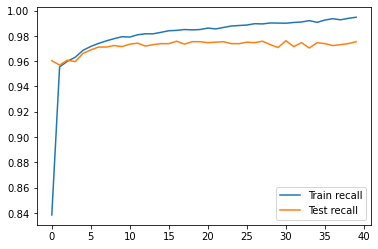

In [64]:
# Check recall curve
plt.plot(history.history['recall'], label='Train recall')
plt.plot(history.history['val_recall'], label='Test recall')
plt.legend()

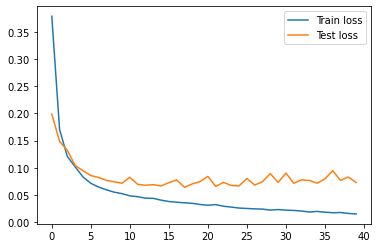

In [65]:
# Check loss curve
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.legend()

In [66]:
# Use argmax to run predictions in multi-class output
pred_labels_sample = np.argmax(model.predict(testing_padded_sample), axis=-1)

# Get predicted labels and convert to original tag
temp_df_sample = pd.DataFrame()
temp_df_sample['pred_labels'] = pred_labels_sample.tolist()
temp_df_sample['pred_labels'] = temp_df_sample['pred_labels'].apply(lambda row: [idx_tag[v] for v in row if idx_tag.get(v)])

# Get test labels and convert to original tag
temp_df_sample['test_labels'] = test_labels_pad_sample.tolist()
temp_df_sample['test_labels'] = temp_df_sample['test_labels'].apply(lambda row: [idx_tag[v] for v in row if idx_tag.get(v)])

# Check df
temp_df_sample

,pred_labels,test_labels
0,"[O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo..."
1,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[O, O, O, O, O, O, O, B-gpe, O, O, O, O, O, O,...","[O, O, O, O, O, O, O, B-gpe, O, O, O, O, O, O,..."
3,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[O, O, O, O, O, B-gpe, I-gpe, O, O, O, O, O, O...","[O, O, O, O, O, B-gpe, I-gpe, O, O, O, O, O, O..."
5,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, B-gpe, O, O, O, O, O, O,..."
6,"[B-per, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[B-per, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
7,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, B-geo, I-geo, O..."
8,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-org,..."
9,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [67]:
# Check classification report
print(classification_report(temp_df_sample['test_labels'], 
                            temp_df_sample['pred_labels'], zero_division=0))

              precision    recall  f1-score   support

         geo       0.67      0.60      0.63        30
         gpe       0.83      0.67      0.74        15
         org       0.17      0.07      0.10        14
         per       0.75      0.75      0.75         8

   micro avg       0.66      0.52      0.58        67
   macro avg       0.60      0.52      0.56        67
weighted avg       0.61      0.52      0.56        67



Our re-training f1 score is only able to go to 0.47. This is due to our small training size.  
As can see from above, the amount of weights/support that each class gets is very limited.  
Thus, it is very hard for us to get any conclusion from this value.

## Predict on Airbnb Dataset

Now that our model has been pre-trained and re-trained, we will now use our model to predict on the entire Airbnb dataset and compare the results to the other NER models.

In [68]:
# Read csv
review = pd.read_csv('../data/cleaned_review.csv', low_memory=False, keep_default_na=False)
# Drop column due to re-run purpose
review = review.drop(columns=['lstm'])

In [69]:
# Check df
review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,length,language,re_comments,nltk,spacy,spacy_retrain
0,49091,8243238,2013-10-21,8557223,Jared,Fran was absolutely gracious and welcoming. Ma...,22,en,Fran was absolutely gracious and welcoming. Ma...,['Fran'],['Fran'],['Would']
1,50646,11909864,2014-04-18,1356099,James,A comfortable room in a smart condo developmen...,39,en,A comfortable room in a smart condo developmen...,['Sujatha'],['Sujatha'],"['Everything', 'Sujatha']"
2,50646,13823948,2014-06-05,15222393,Welli,Stayed over at Sujatha's house for 3 good nigh...,71,en,Stayed over at Sujatha's house for 3 good nigh...,"['Good', 'Sujatha']","['A few minutes', '3', 'Sujatha']","['Highly', 'Stayed', 'Sujatha']"
3,50646,15117222,2014-07-02,5543172,Cyril,It's been a lovely stay at Sujatha's. The room...,42,en,It's been a lovely stay at Sujatha's. The room...,"['Singapore', 'Sujatha']","['the day', 'Singapore', 'Sujatha']","['Thank', 'Singapore', 'Sujatha']"
4,50646,15426462,2014-07-08,817532,Jake,"We had a great experience. A nice place, an am...",17,en,"We had a great experience. A nice place, an am...",[],[],[]


In [70]:
# Create temp df
temp_review = review[['id','re_comments']].copy()

# Segment reviews into multiple sentences
temp_review['re_comments'] = temp_review['re_comments'].map(lambda x: x.split('.'))
# Un-nest the segments into their own rows
temp_review = temp_review.explode('re_comments')

# Add space in front of commas
temp_review['re_comments'] = temp_review['re_comments'].map(lambda x: x.replace(',',' ,'))

# Tokenize each words in each segments via split on whitespace
temp_review['re_comments'] = temp_review['re_comments'].map(lambda x: x.split())

In [71]:
# Check df
temp_review

,id,re_comments
0,8243238,"[Fran, was, absolutely, gracious, and, welcoming]"
0,8243238,"[Made, my, stay, a, great, experience]"
0,8243238,"[Would, definitely, recommend, this, cozy, and..."
0,8243238,[]
1,11909864,"[A, comfortable, room, in, a, smart, condo, de..."
...,...,...
42221,730449201,[]
42222,734174491,"[Beautiful, and, cozy, apartment]"
42222,734174491,"[Great, location]"
42222,734174491,"[However, ,, a, little, too, expensive, for, i..."


In [72]:
# Similar steps when we run our modelling
# Define segments into a list so model can predict
to_pred_rev = temp_review['re_comments'].tolist()

# Convert segments into sequences of numbers then pad to model max length
pred_rev_sequences = tokenizer.texts_to_sequences(to_pred_rev)
pred_rev_sequences_padded = pad_sequences(pred_rev_sequences, maxlen=max_len, 
                                          padding=padding_type, truncating=trunc_type, value=n_words - 1)

# Convert into array
pred_rev = np.array(pred_rev_sequences_padded)

In [73]:
# Use argmax to compute predictions
predicted_rev = np.argmax(model.predict(pred_rev), axis=-1)

In [74]:
# Add the predictions into temp df
temp_review['predicted_array'] = predicted_rev.tolist()

In [75]:
# Convert the tags from numeric to original labels
temp_review['idx_tags'] = temp_review['predicted_array'].apply(lambda row: [idx_tag[v] for v in row if idx_tag.get(v)])

In [76]:
# Check df
temp_review

,id,re_comments,predicted_array,idx_tags
0,8243238,"[Fran, was, absolutely, gracious, and, welcoming]","[8, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15...","[B-per, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
0,8243238,"[Made, my, stay, a, great, experience]","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
0,8243238,"[Would, definitely, recommend, this, cozy, and...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
0,8243238,[],"[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,11909864,"[A, comfortable, room, in, a, smart, condo, de...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...,...
42221,730449201,[],"[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
42222,734174491,"[Beautiful, and, cozy, apartment]","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
42222,734174491,"[Great, location]","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
42222,734174491,"[However, ,, a, little, too, expensive, for, i...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


### Extract Entity from Bi-LSTM Predictions

In order to extract the entities out from the predicted labels, we need to create a function that can merge words together if they are in the same tag, rather than giving us mutliple separated words.

Example:-

Sentence:   I    love    New    York  
    Tags:   O     O     B-geo   I-geo  
    
Extracted entity: New York   (NOT 'New', 'York' which is 2 separate words)

In [77]:
# Function to extract entity our based on tags
def extract_entity(word,tag):
    named_entities = []
    temp_entity_name = ''
    temp_named_entity = None
    temp_tag = None
    for term, tag in zip(word,tag):
        if tag != 'O':
            if temp_tag == None:
                temp_entity_name = ' '.join([temp_entity_name, term]).strip()
                temp_named_entity = temp_entity_name
                temp_tag = tag[2:]
            elif (temp_tag != None) & (tag[2:] == temp_tag):
                temp_entity_name = ' '.join([temp_entity_name, term]).strip()
                temp_named_entity = temp_entity_name
                temp_tag = tag[2:]
            elif (temp_tag != None) & (tag[2:] != temp_tag):
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None
                temp_entity_name = ' '.join([temp_entity_name, term]).strip()
                temp_named_entity = temp_entity_name
                temp_tag = tag[2:]
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None
                temp_tag = None
    if temp_named_entity != None:
        named_entities.append(temp_named_entity)

    named_entities = list(set(named_entities))

    return (named_entities)

In [78]:
# Run function on the tags and words columns
extracts = []
for splits, tags in zip(temp_review['re_comments'], temp_review['idx_tags']):
    extracts.append(extract_entity(splits,tags))
temp_review['extracted'] = extracts

In [79]:
# Check df
temp_review

,id,re_comments,predicted_array,idx_tags,extracted
0,8243238,"[Fran, was, absolutely, gracious, and, welcoming]","[8, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15...","[B-per, O, O, O, O, O, O, O, O, O, O, O, O, O,...",[Fran]
0,8243238,"[Made, my, stay, a, great, experience]","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
0,8243238,"[Would, definitely, recommend, this, cozy, and...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
0,8243238,[],"[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
1,11909864,"[A, comfortable, room, in, a, smart, condo, de...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
...,...,...,...,...,...
42221,730449201,[],"[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
42222,734174491,"[Beautiful, and, cozy, apartment]","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
42222,734174491,"[Great, location]","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
42222,734174491,"[However, ,, a, little, too, expensive, for, i...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]


In [80]:
# Because we segmented each review, we need to merge them back in order to get the original review
temp_review = temp_review.groupby('id').agg({'re_comments':'sum','predicted_array':'sum',
                                      'idx_tags':'sum','extracted':'sum'}).reset_index()

In [81]:
# Check df
temp_review

,id,re_comments,predicted_array,idx_tags,extracted
0,251467,"[I, stayed, at, Belinda's, place, for, 4, nigh...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[Changi, Simei, Jalan Pelatok, Simei Street, p..."
1,286886,"[A, wonderful, house, with, all, the, amenitie...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
2,298698,"[This, is, a, great, place, with, great, peopl...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[Singapore]
3,333890,"[Fran, is, an, excellent, host, who, provided,...","[8, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15...","[B-per, O, O, O, O, O, O, O, O, O, O, O, O, O,...",[Fran]
4,352553,"[Fran, and, family, were, absolutely, fabulous...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[singapore]
...,...,...,...,...,...
42218,733995329,"[Host, is, so, friendly, and, helpful, Definit...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
42219,733996314,"[The, stay, was, simply, great!, The, walking,...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[intern Clarence, meals!]"
42220,734000592,"[It, is, a, great, place, to, stay, and, the, ...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]
42221,734174491,"[Beautiful, and, cozy, apartment, Great, locat...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",[]


In [82]:
# Create temp df
temp_review_ext = temp_review[['id','extracted']].copy()
temp_review_ext.rename({'extracted': 'lstm'}, axis=1, inplace=True)

# Then use merge function onto the review csv table
review = review.merge(temp_review_ext, how='left', on='id')

# After being merged, there may be duplicates, hence do list-set to get unique values
review['lstm'] = review['lstm'].map(lambda x: list(set(x)))

In [83]:
# Check df
review.head()
#review = review.drop(columns=['lstm'])

,listing_id,id,date,reviewer_id,reviewer_name,comments,length,language,re_comments,nltk,spacy,spacy_retrain,lstm
0,49091,8243238,2013-10-21,8557223,Jared,Fran was absolutely gracious and welcoming. Ma...,22,en,Fran was absolutely gracious and welcoming. Ma...,['Fran'],['Fran'],['Would'],[Fran]
1,50646,11909864,2014-04-18,1356099,James,A comfortable room in a smart condo developmen...,39,en,A comfortable room in a smart condo developmen...,['Sujatha'],['Sujatha'],"['Everything', 'Sujatha']",[]
2,50646,13823948,2014-06-05,15222393,Welli,Stayed over at Sujatha's house for 3 good nigh...,71,en,Stayed over at Sujatha's house for 3 good nigh...,"['Good', 'Sujatha']","['A few minutes', '3', 'Sujatha']","['Highly', 'Stayed', 'Sujatha']",[]
3,50646,15117222,2014-07-02,5543172,Cyril,It's been a lovely stay at Sujatha's. The room...,42,en,It's been a lovely stay at Sujatha's. The room...,"['Singapore', 'Sujatha']","['the day', 'Singapore', 'Sujatha']","['Thank', 'Singapore', 'Sujatha']",[Singapore]
4,50646,15426462,2014-07-08,817532,Jake,"We had a great experience. A nice place, an am...",17,en,"We had a great experience. A nice place, an am...",[],[],[],[]


In [84]:
# Save the review.csv file
review.to_csv('../data/cleaned_review.csv', index = False)

In [85]:
# Creates a list of entities and counts of entities
lstm_list = review.explode('lstm')['lstm'].value_counts()

# Create temporary df to get count of entities obtained by spacy model
lstm_df = pd.DataFrame()
lstm_df['place'] = lstm_list.index
lstm_df['lstm_count'] = lstm_list.values

In [86]:
# Call count.csv
count = pd.read_csv('../data/count.csv')

# Compare NER's recognized from spaCy to true count
count = count.merge(lstm_df, how='left', on='place')

# Fill NA 
count.fillna(0, inplace=True)
count['lstm_count'] = count['lstm_count'].map(lambda x: int(x))

# Save count.csv
#count.to_csv('../data/count.csv', index = False)

In [87]:
# Check df
count

,place,count,nltk_count,spacy_count,spacy_retrain_count,lstm_count
0,Marina Bay Sands,86,72,60,83,54
1,East Coast Park,54,25,36,51,41
2,Boat Quay,57,43,41,52,36
3,Clarke Quay,192,170,162,185,158
4,Arab Street,38,35,2,28,32
5,Little India,517,374,391,499,484
6,Bugis Junction,50,46,44,50,26
7,Tanjong Pagar,49,36,31,48,31
8,Tiong Bahru,111,77,88,110,48
9,Farrer Park,135,91,79,127,83


<u>**Reviewing back sample from Notebook 01**</u>

In [94]:
pd.set_option('display.max_colwidth', None)

# Random check on models' extracted entities
review[review.index==4267][['comments','nltk','spacy','spacy_retrain','lstm']]

,comments,nltk,spacy,spacy_retrain,lstm
4267,"Kel is very friendly and always willing to help. We are staying so enjoyable. Fantastic location, there are free shuttle bus to Orchard Road and China Town. I got a great time in Singapore with my family. Highly recommend to anyone wanting to visit Singapore.","['Orchard Road', 'Kel', 'Singapore', 'Fantastic', 'China Town']","['Orchard Road', 'Singapore']","['visit Singapore.', 'Orchard Road', 'Highly', 'Singapore', 'Fantastic', 'China Town']","[Kel, Orchard Road, China, Singapore]"


The NLTK model over-extract the word 'Fantastic' while the base spaCy pipeline under-extract the word 'Kel' and 'China Town'.
However, the retrained pipeline seems to extract some unnecessary words like 'visit', 'Highly', and 'Fantastic'.
Based on further check, we noticed that the model will likely extract the first word out of every sentences.

Our LSTM model was able to extract the closest of the other models. Although there is an error in the way China Town is written, the model was able to extract the country 'China' from the text.

## Save Model

In [91]:
# We will save our model out so that we can use it anywhere
#model.save("../data/model.h5")

# Method to load model
#model = load_model('../data/model.h5')

## Model Evaluation and Discussion

### Fine-tuning Model

| Finetune Item                      | f1 Score | Change | Remark                 |
|------------------------------------|:--------------:|:------:|------------------------|
| (Basic Bi-LSTM)                    | 0.76           | NA     | Vanilla Model          |
| Add 0.25 dropout                   | 0.74           | -0.02  |                        |
| Add dropout + Dense layer          | 0.73           | -0.03  |                        |
| Increase training size by 20%      | 0.77           | +0.01  |                        |
| Increase embedding size (32 to 50) | 0.77           | 0.00   | With new training size |
| Use GloVe embedding (50D)          | 0.78           | +0.01  | With new training size |
| Change to GloVe 100D embedding     | 0.79           | +0.02  | With new training size |
| Reduce learning rate to 0.0005.    | 0.79           | 0.00   | With new training size |

During our modelling fine-tuning process, we tried to tweak different types of parameter, add depth to the model topology and tried using different pre-trained embeddings. The table above shows how each change will affect the results of our model.  

What worked for us was mainly two things:
1. Increasing training size
2. Use of GloVe embedding

### Best Model For NER (Airbnb Dataset)

For this particular task of predicting NER from the Airbnb dataset, we will look into the how many named entities can each different model extract based on the given list.  

Since we already have our total count table, we can observe the percentage in terms of the actual sweep-through count. Ideally, the model should be able to get as close to 1 as possible.

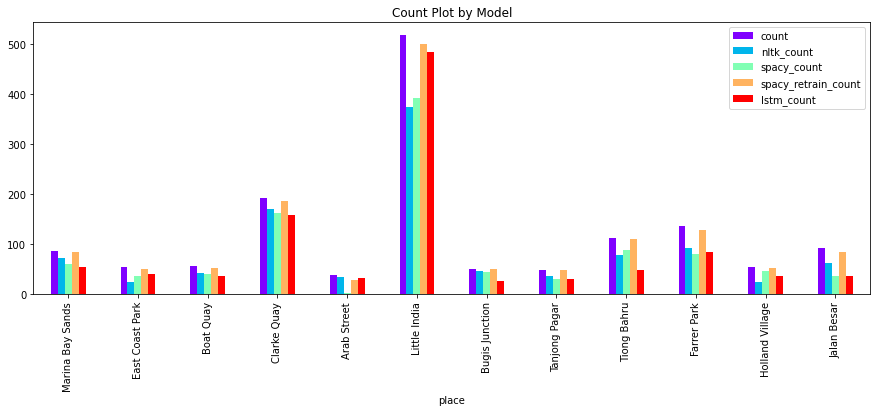

In [90]:
# Plot number of counts distribution
count.plot.bar(figsize=(15,5), title='Count Plot by Model', x='place', colormap='rainbow');

Based on our plot above, we can observe which entity does a model predict good and bad at.  
The bar counts for the NLTK, base spaCy and our Bi-LSTM models seem to be lower than the re-trained spaCy models across all labels.

The NLTK and spaCy model seems to lose ground over the entity Little India and could very likely lose out. One idea why this might happen could be because the models recognize the individual word 'India' as a country, and lost out on the context that 'Litle India' could be a geo-political entity.

In [89]:
# Count the amount of entities recognized by each model
count[['count','nltk_count','spacy_count','spacy_retrain_count','lstm_count']].sum() / count['count'].sum()

count                  1.000000
nltk_count             0.735889
spacy_count            0.708711
spacy_retrain_count    0.954007
lstm_count             0.742857
dtype: float64

The re-trained spaCy model performed the best with a close score of 95%, followed by our Bi-LSTM model, the NLTK model and then the base spaCy model.  

**Hence, if we ever need to run a model in production, we can consider to apply the spaCy model re-trained to our specific task at hand**

There seems to be a pattern here as well because the **re-trained** models outperform the un-retrained models.  
This would be an extreme advantage and could even cause the models to become overfitted to our training data.

Not to mention that it is quite difficult to perform a failure analysis on each model on where it tags wrong, this model assessment is not the most accurate way to score each model. However, there is no specific way either in how NLP models are assessed as each models are built and trained very different to each other, and metrics could be misleading.

### Model Comparison (Discussion)

As mentioned above, it is very hard to judge each model based on a token-level evaluation. Let's look deeper into the details of each model:

| Model | Data                         | Data Source                                                                                                           | Model Type                 | Entities                                                                                                                              | F1 Score                |
|-------|------------------------------|-----------------------------------------------------------------------------------------------------------------------|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------|-------------------------|
| NLTK  | ACE 2004                     | newswire, broadcast news, telephone conversations                                                                     | MaxEnt classifier          | Organization, Person, Location, Date, Time, Money, Percent, Facility, GPE                                                             | 0.89 ± 0.11 |
| spaCy | OntoNotes                    | telephone conversations, newswire, newsgroups, broadcast news, broadcast conversation, weblogs                        | CNN with GloVe vectors     | Person, Norp, Fac, Org, Gpe, Loc, Product, Event, Work_Of_Art, Law, Language, Date, Time, Percent, Money, Quantity, Ordinal, Cardinal | 0.8585     |
| Bi-LSTM   | GMB (Groningen Meaning Bank) | documents authored by Voice of America VOA, together with documents from the MASC dataset and the CIA World Factbook. | Bi-LSTM with GloVe vectors | Person, GPE, GEO, Organization, Time, Event, Nationality, Art                                                                         | 0.79~0.80               |

Data in table are extracted from [Pahul](https://pahulpreet86.github.io/name-entity-recognition-pre-trained-models-review/). Above only shows the f1 score of our Bi-LSTM model before we re-train it on the Airbnb review dataset.

**Observations**

1. Each model uses different training dataset (each dataset has different sources/backgrounds)
2. Each model uses different architecture (spaCy uses CNN while our model is based on RNNs)
3. Each model has different entity tags (tags can be added when you train the model)
4. Although NLTK has the highest f1 score, followed by spaCy then our Bi-LSTM model, we will not be able to use this as a straight-up comparison because the model build-up is vastly different!

In actuality, it is very different to compare each model straight up because there are many information about a given word that can be learned to recognize if it is a Named Entity:
* 		Capitalization
* 		Prefix, suffix
* 		POS Tag
* 		Relative location in the sentence (beginning, end, etc.)
* 		Other words in the sentence.
* 		Whether the word is ‘OOV’ (Out Of Vocabulary)

Each model have different weightages and will output slightly different set to tags or even make different assumptions based on how the model tokenize the sentences.

For example, there are many extra categories that spaCy uses compared to NLTK, and this will affect its output results.

There is a new paper by Jinlan Fu, Pengfei Liu and Graham Neublg from Fudan U. and Carnegie Mellon U..  
It addresses a better way to evaluate different NER models.

<img src="../images/paper.png" width="600">

Essentially, we can divide the dataset into different categories of entities (as below) and evaluate the models based on each aspect separately. This makes it much easier to identify and quantify where the models perform good or bad.

* Entity Length: String length of the entity
* Sentence Length
* OOV Density: Fraction of ‘Out of Vocabulary’ words in the sentence
* Entity Density: Number of entities in a sentence
* Token Label Consistency: This is a measure of how versatile an entity is.
* Token frequency: How many times the token appears in the dataset
* Entity Label Consistency : Same as Token Label Consistency, but calculated for entity text instead of tokens.
* Entity Frequency : Same as Token Frequency, but calculated for entity text instead of tokens.

We can find out which attributes of the data affect the performance the model, choose the best suited model based on the type of data that you plan to feed it and more importantly know where to apply improvement actions.

**However, this is only for discussion and recommendation for improvement purpose and will not be applied in this project**

## Conclusion and Recommendation

<u>**Conclusion**</u>

Based on our work, we conclude that the re-trained spaCy model works best for predicting named entities from the Airbnb review dataset. However, it might not be the best model in performing NER as a whole.  

Each model has its own performance highs and lows, and as such we can consider to fine-tune each model or even re-train them in order to get each model to work for each of our task individually.

### Further Improvement

Below are some of our recommendations on how to improve upon the model:

- Add a CRF (Conditional Random Field) layer after the Bi-LSTM output
    - We wanted to add this but unfortunately Keras has stopped supporting CRF layer
    - There is a TensorflowAddOn for CRF but due to lack of documentation, we do not have enough time to figure it out
    
    
- Try other pre-trained embeddings such as Elmo or BERT-like models


- Increase training set
    - As observed above, the total words is more than number of word embeddings, thus some words are not recognised
    - These words will be tagged as OOV and reduces the accuracy of the model
    
    
- Increase re-training sample size
    - More examples to train on


- Go fully character-based. Eliminate word-level embeddings all together.


- Try out the model evaluation process as written by Jinlan Fu, Pengfei Liu and Graham Neublg